In [1]:
import sys

sys.path.append("../../src")
from main.transporter_dataset import create_dataset
from main.cdhit import cd_hit
from main.eval import (
    optimize_hyperparams,
    preprocess_pandas,
    get_confusion_matrix,
    get_classification_report,
    get_independent_test_set,
    quick_test,
    full_test
)
from main.compositions import calculate_aac, calculate_paac
from main.pssm import calculate_pssms_notebook
import matplotlib.pyplot as plt
import seaborn as sns

LOG_FILE = "../../logs/athaliana_amino_sugar_potassium.log"

In [2]:
sodium = ["Q2UVJ5", "O04034", "Q9FKP1", "Q9LJI2", "Q9SYG9", "Q84TI7"]
gdu = ["O81775", "Q9SW07", "Q9FHH5", "Q8S8A0", "Q3E965", "Q3EAV6", "Q3E8L0"]
df_all = create_dataset(
    keywords_substrate_filter=[
        # "Amino-acid transport",
        "Electron transport",
        "Sugar transport",
        "Potassium transport",
    ],
    keywords_component_filter=["Transmembrane"],
    keywords_transport_filter=["Transport"],
    input_file="../../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate="integrate",
    outliers=gdu + sodium,
    verbose=True,
    tax_ids_filter=[3702],
    output_log=LOG_FILE,
    sequence_clustering=70,
)


cd-hit: clustered 250 sequences into 190 clusters at threshold 70


# Feature generation

In [3]:
df_aac = calculate_aac(df_all.sequence)
df_paac = calculate_paac(df_all.sequence)
df_pssm = calculate_pssms_notebook(df_all.sequence)
labels = df_all.keywords_transport
labels.value_counts()

Sugar transport        84
Electron transport     56
Potassium transport    50
Name: keywords_transport, dtype: int64

# Eval AAC

############################################################
Feature reduction:  None
############################################################


,0,1,2,3,4,5,6,7,8,9
svc__C,10,1,1,1,10,1,1,10,1,1
svc__class_weight,balanced,balanced,None,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__decision_function_shape,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo
svc__gamma,0.1,scale,0.1,scale,scale,scale,scale,0.1,scale,scale


F1 score       
dataset                 test  train
label                              
Electron transport     0.879  0.921
Potassium transport    0.984  0.956
Sugar transport        0.924  0.944
mean                   0.929  0.940

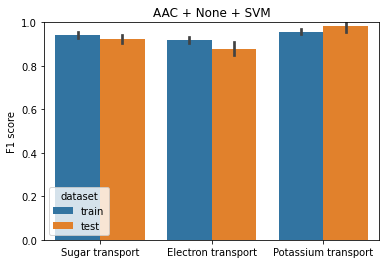

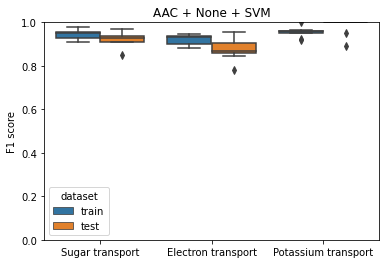

############################################################
Feature reduction:  pca
############################################################


,0,1,2,3,4,5,6,7,8,9
pca__n_components,0.94,0.94,0.91,0.96,0.96,0.94,0.94,0.91,0.9,0.85
svc__C,10,10,10,10,10,10,1,10,1,1
svc__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,None,balanced
svc__decision_function_shape,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo
svc__gamma,0.1,scale,0.1,0.1,scale,scale,scale,scale,0.1,0.1


F1 score       
dataset                 test  train
label                              
Electron transport     0.867  0.913
Potassium transport    0.968  0.953
Sugar transport        0.918  0.945
mean                   0.918  0.937

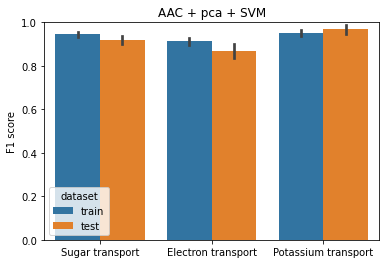

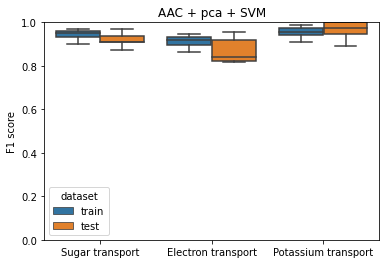

############################################################
Feature reduction:  kbest
############################################################


,0,1,2,3,4,5,6,7,8,9
selectkbest__k,16,16,14,19,15,19,17,19,18,14
svc__C,1,10,1,1,10,10,1,10,10,1
svc__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__decision_function_shape,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo
svc__gamma,0.1,scale,0.1,scale,scale,scale,scale,0.1,scale,scale


F1 score       
dataset                 test  train
label                              
Electron transport     0.883  0.931
Potassium transport    0.969  0.973
Sugar transport        0.930  0.949
mean                   0.927  0.951

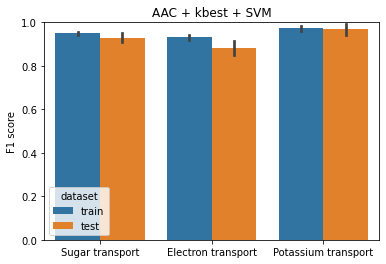

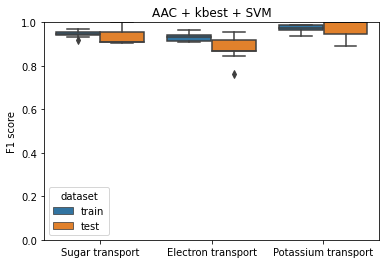

In [4]:
for dim_reduction in [None, "pca", "kbest"]:
    print("#"*60)
    print("Feature reduction: ", dim_reduction)
    print("#"*60)
    df_scores, df_params = full_test(df_aac, labels, kernel="rbf", dim_reduction=dim_reduction)

    display(df_params)
    df_scores_piv = df_scores.groupby(["label", "dataset"]).mean().unstack(1)
    df_scores_piv.loc["mean"] = df_scores_piv.mean()
    display(df_scores_piv.round(3))

    g = sns.barplot(data=df_scores, y="F1 score", x="label", hue="dataset")
    g.set_ylim((0,1))
    g.set_xlabel("")
    g.set_title(f"AAC + {dim_reduction} + SVM")
    plt.show()

    g = sns.boxplot(data=df_scores, y="F1 score", x="label", hue="dataset")
    g.set_xlabel("")
    g.set_ylim((0,1))
    g.set_title(f"AAC + {dim_reduction} + SVM")
    plt.show()

# Eval PAAC

############################################################
Feature reduction:  None
############################################################


,0,1,2,3,4,5,6,7,8,9
svc__C,10,10,1,10,1,10,10,10,10,10
svc__class_weight,balanced,balanced,None,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__decision_function_shape,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo
svc__gamma,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale


F1 score       
dataset                 test  train
label                              
Electron transport     0.926  0.870
Potassium transport    0.956  0.935
Sugar transport        0.979  0.944
mean                   0.954  0.916

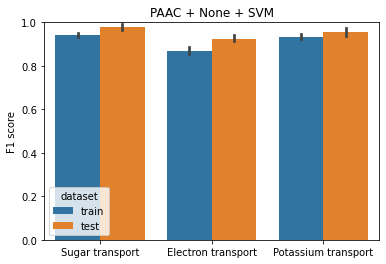

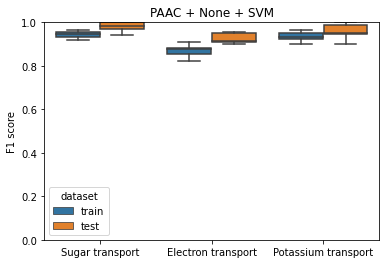

############################################################
Feature reduction:  pca
############################################################


,0,1,2,3,4,5,6,7,8,9
pca__n_components,0.8,0.99,0.99,0.99,0.99,0.8,0.99,0.8,0.86,0.8
svc__C,10,1,1,1,1,10,1,10,10,10
svc__class_weight,None,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__decision_function_shape,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo
svc__gamma,0.01,scale,scale,scale,scale,0.01,scale,0.01,0.01,0.01


F1 score       
dataset                 test  train
label                              
Electron transport     0.679  0.536
Potassium transport    0.764  0.739
Sugar transport        0.815  0.775
mean                   0.753  0.683

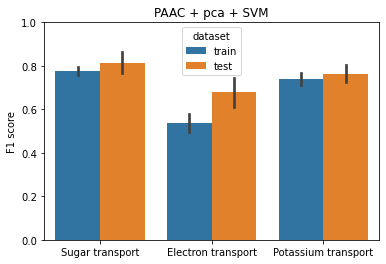

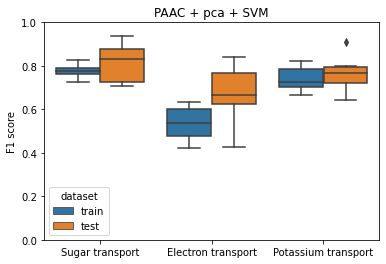

############################################################
Feature reduction:  kbest
############################################################


,0,1,2,3,4,5,6,7,8,9
selectkbest__k,299,315,208,239,123,378,325,300,236,397
svc__C,1,10,10,1,10,10,10,10,10,10
svc__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__decision_function_shape,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo
svc__gamma,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale


F1 score       
dataset                 test  train
label                              
Electron transport     0.922  0.903
Potassium transport    0.961  0.952
Sugar transport        0.967  0.952
mean                   0.950  0.936

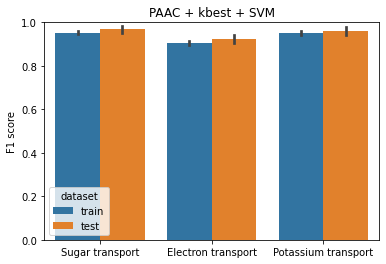

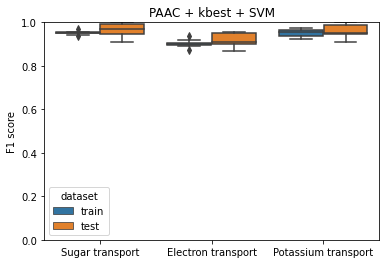

In [5]:
for dim_reduction in [None, "pca", "kbest"]:
    print("#"*60)
    print("Feature reduction: ", dim_reduction)
    print("#"*60)
    df_scores, df_params = full_test(df_paac, labels, kernel="rbf", dim_reduction=dim_reduction)

    display(df_params)
    df_scores_piv = df_scores.groupby(["label", "dataset"]).mean().unstack(1)
    df_scores_piv.loc["mean"] = df_scores_piv.mean()
    display(df_scores_piv.round(3))

    g = sns.barplot(data=df_scores, y="F1 score", x="label", hue="dataset")
    g.set_ylim((0,1))
    g.set_xlabel("")
    g.set_title(f"PAAC + {dim_reduction} + SVM")
    plt.show()

    g = sns.boxplot(data=df_scores, y="F1 score", x="label", hue="dataset")
    g.set_xlabel("")
    g.set_ylim((0,1))
    g.set_title(f"PAAC + {dim_reduction} + SVM")
    plt.show()

# PSSM

############################################################
Feature reduction:  None
############################################################


,0,1,2,3,4,5,6,7,8,9
pssmselector__iterations,1,1,1,1,1,1,1,1,1,1
pssmselector__uniref_threshold,50,50,50,50,50,50,50,50,50,50
svc__C,10,1,10,10,10,10,1,10,10,10
svc__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__decision_function_shape,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo
svc__gamma,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale


F1 score       
dataset                 test  train
label                              
Electron transport     0.987  0.986
Potassium transport    0.995  0.984
Sugar transport        0.994  0.988
mean                   0.992  0.986

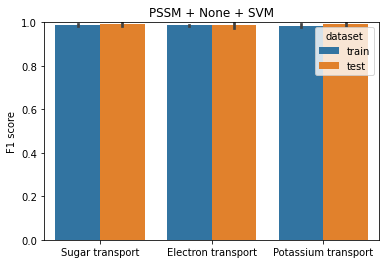

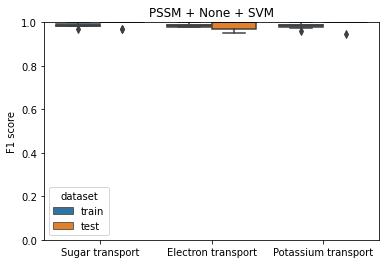

############################################################
Feature reduction:  kbest
############################################################


,0,1,2,3,4,5,6,7,8,9
pssmselector__iterations,1,1,1,1,1,1,1,1,1,1
pssmselector__uniref_threshold,50,50,50,50,50,50,50,50,50,50
selectkbest__k,511,331,1501,1231,301,1441,1051,601,1551,1531
svc__C,10,10,10,10,10,10,1,10,10,10
svc__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__decision_function_shape,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo
svc__gamma,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale


F1 score       
dataset                 test  train
label                              
Electron transport     0.991  0.989
Potassium transport    0.995  0.988
Sugar transport        0.997  0.989
mean                   0.994  0.989

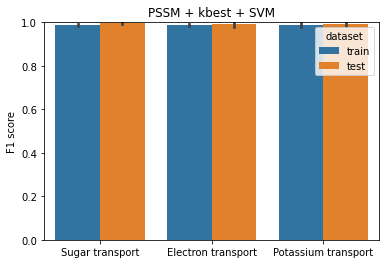

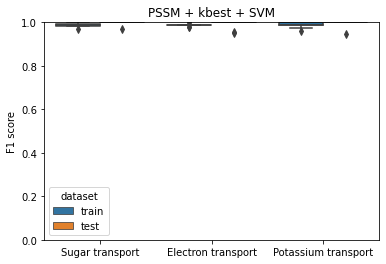

In [6]:
for dim_reduction in [None, "kbest"]:
    print("#" * 60)
    print("Feature reduction: ", dim_reduction)
    print("#" * 60)
    df_scores, df_params = full_test(
        df_pssm,
        labels,
        kernel="rbf",
        dim_reduction=dim_reduction,
        feature_filter="pssm",
        select_k_steps=10,
    )

    display(df_params)
    df_scores_piv = df_scores.groupby(["label", "dataset"]).mean().unstack(1)
    df_scores_piv.loc["mean"] = df_scores_piv.mean()
    display(df_scores_piv.round(3))

    g = sns.barplot(data=df_scores, y="F1 score", x="label", hue="dataset")
    g.set_ylim((0, 1))
    g.set_xlabel("")
    g.set_title(f"PSSM + {dim_reduction} + SVM")
    plt.show()

    g = sns.boxplot(data=df_scores, y="F1 score", x="label", hue="dataset")
    g.set_xlabel("")
    g.set_ylim((0, 1))
    g.set_title(f"PSSM + {dim_reduction} + SVM")
    plt.show()
